## ARIMA Model Fine Tuning
This notebook used to sandboxing and perform Exploratory Data Analysis for the IoT dataset that we've downloaded from Kaggle. In this notebook, we also want to fine tune the model to reach the best parameters before implement it in the real dataset.

In [118]:
# Import library
import numpy as np
import seaborn as sns 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [119]:
# Import dataset and read as dataframe
import os

file_path = "C:/Kuliah/Semester 6/Signal Processing and Multimedia Services/Project/pslm-project/data/esp32_2_data.csv"

if os.path.exists(file_path):
  df = pd.read_csv(file_path)
else:
  print("File not found!")

# Print top 5 rows of the dataset
df.head()

,timestamp,temperature,humidity(%),latency(ms),throughput(bytes/sec),packet_loss(%),rssi(dBm)
0,2025-05-12 | 10:14:36,28.7,72.0,0.235840,0.054,0.0,-55
1,2025-05-12 | 10:14:37,28.7,71.9,0.257324,0.054,0.0,-57
2,2025-05-12 | 10:14:40,28.8,71.8,0.309570,0.054,0.0,-64
3,2025-05-12 | 10:14:42,28.8,71.6,0.308838,0.054,0.0,-59
4,2025-05-12 | 10:14:43,28.8,71.6,1.004150,0.054,0.0,-60


### Data Preprocessing

In [120]:
# Change the time column to datetime format and split it into date and time
df["timestamp"] = pd.to_datetime(df["timestamp"], format="%Y-%m-%d | %H:%M:%S")

# Resample using timestamp and take the mean of each minute
df = df.set_index("timestamp")
df_resampled = df.resample("min").mean()

In [121]:
# Reset index to get timestamp back as a column
df_resampled = df_resampled.reset_index()

# Check the shape of the dataset
print(f"Dataset shape after resampling: {df_resampled.shape}")

# Check the null values
print(f"Null values in the dataset after resampling\n{df_resampled.isnull().sum()}")

Dataset shape after resampling: (1896, 7)
Null values in the dataset after resampling
timestamp                  0
temperature              118
humidity(%)              118
latency(ms)              118
throughput(bytes/sec)    118
packet_loss(%)           118
rssi(dBm)                118
dtype: int64


In [122]:
# Set time column as index
df_resampled.set_index("timestamp", inplace=True)

In [123]:
# Imputate the null values with the mean of the column
df_resampled.fillna(df_resampled.mean(), inplace=True)

# Check the null values
print(f"Null values in the dataset after imputating\n{df_resampled.isnull().sum()}")

Null values in the dataset after imputating
temperature              0
humidity(%)              0
latency(ms)              0
throughput(bytes/sec)    0
packet_loss(%)           0
rssi(dBm)                0
dtype: int64


In [124]:
# Reset the time index
df_resampled.reset_index(inplace=True)

In [125]:
# Convert the timestamp to time string
df_resampled["time_str"] = df_resampled["timestamp"].dt.strftime("%H:%M")

# Set the time_str as index
df_resampled.set_index("timestamp", inplace=True)

In [126]:
# Show the data in 24 Hours from 12:00:00 to 12:00:00
df_day_one = df_resampled.loc["2025-05-12 12:00:00":"2025-05-13 12:00:00"]

### Data Visualization

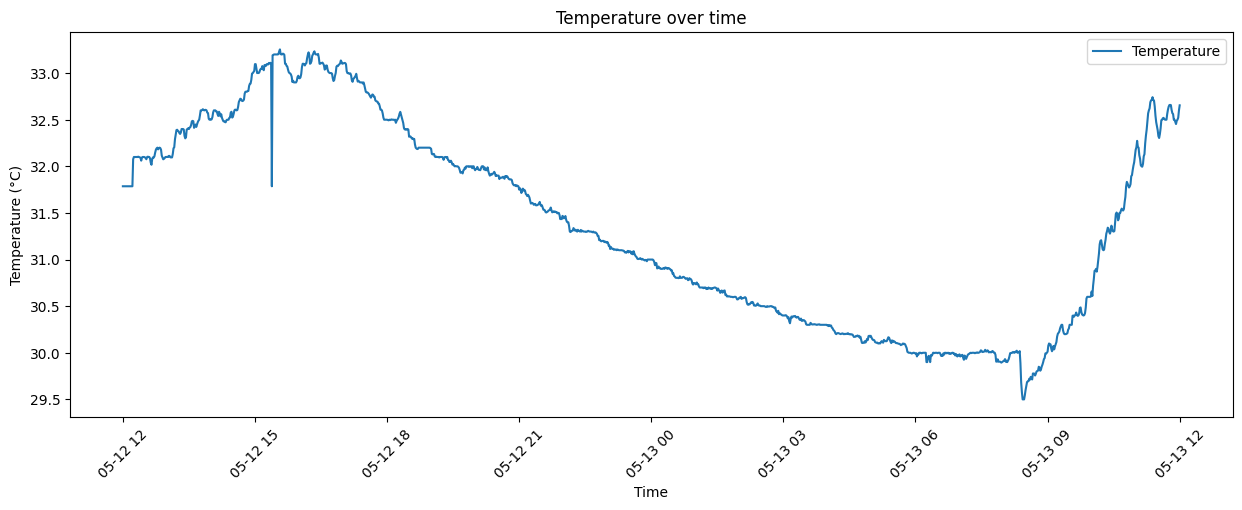

In [127]:
# Plot the temperature over time
plt.figure(figsize=(15, 5))
sns.lineplot(data=df_day_one, x=df_day_one.index, y="temperature", label="Temperature")
plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.title("Temperature over time")
plt.xticks(rotation=45)
plt.show()

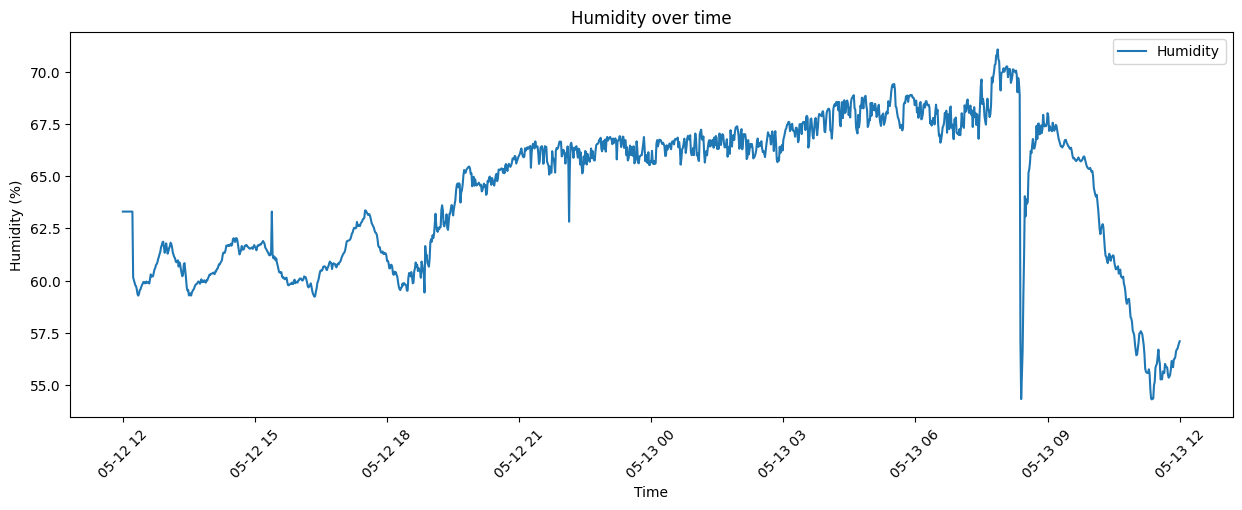

In [128]:
# Plot the humidity over time
plt.figure(figsize=(15, 5))
sns.lineplot(data=df_day_one, x=df_day_one.index, y="humidity(%)", label="Humidity")
plt.xlabel("Time")
plt.ylabel("Humidity (%)")
plt.title("Humidity over time")
plt.xticks(rotation=45)
plt.show()

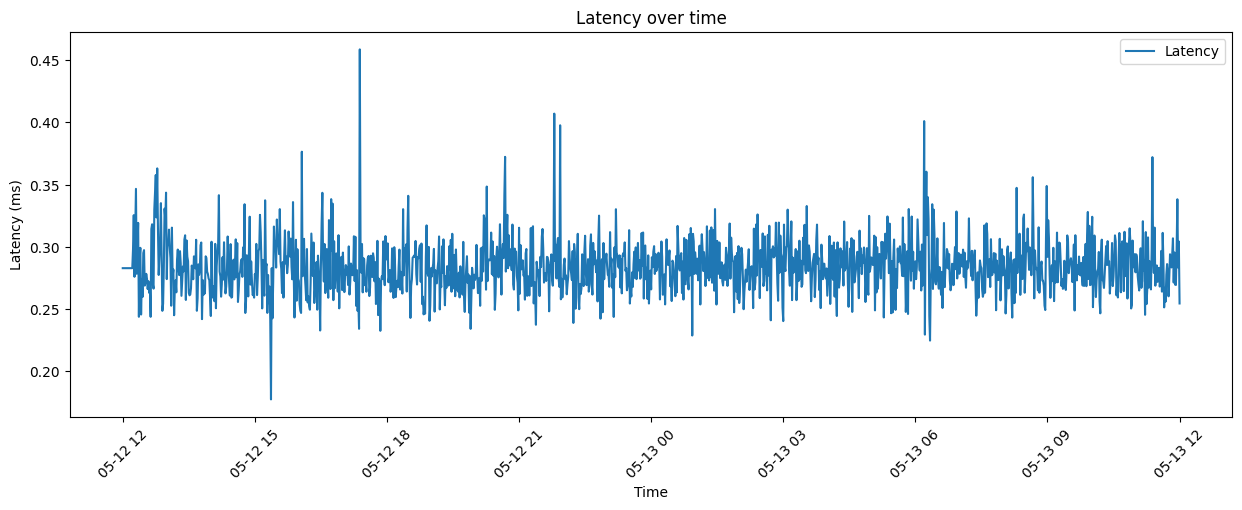

In [129]:
# Plot the latency over time
plt.figure(figsize=(15, 5))
sns.lineplot(data=df_day_one, x=df_day_one.index, y="latency(ms)", label="Latency")
plt.xlabel("Time")
plt.ylabel("Latency (ms)")
plt.title("Latency over time")
plt.xticks(rotation=45)
plt.show()

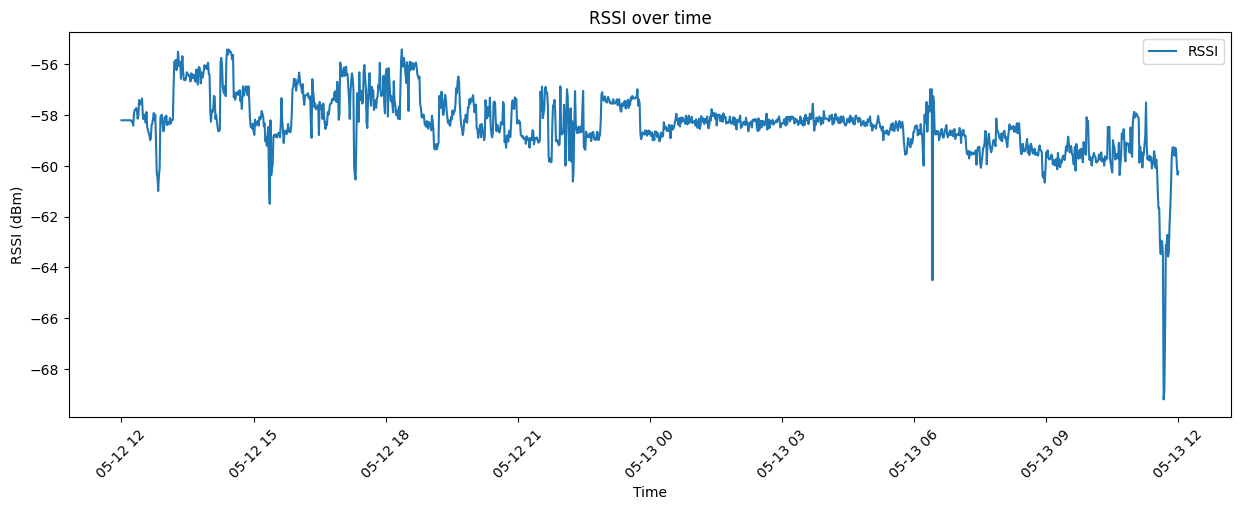

In [130]:
# Plot the RSSI over time
plt.figure(figsize=(15, 5))
sns.lineplot(data=df_day_one, x=df_day_one.index, y="rssi(dBm)", label="RSSI")
plt.xlabel("Time")
plt.ylabel("RSSI (dBm)")
plt.title("RSSI over time")
plt.xticks(rotation=45)
plt.show()

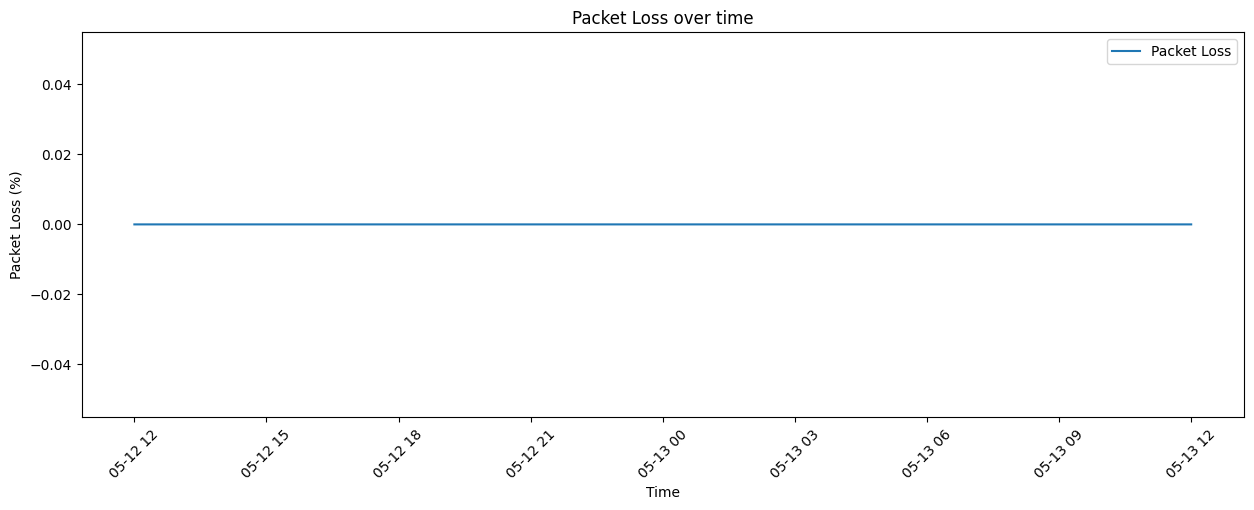

In [131]:
# Plot the RSSI over time
plt.figure(figsize=(15, 5))
sns.lineplot(data=df_day_one, x=df_day_one.index, y="packet_loss(%)", label="Packet Loss")
plt.xlabel("Time")
plt.ylabel("Packet Loss (%)")
plt.title("Packet Loss over time")
plt.xticks(rotation=45)
plt.show()

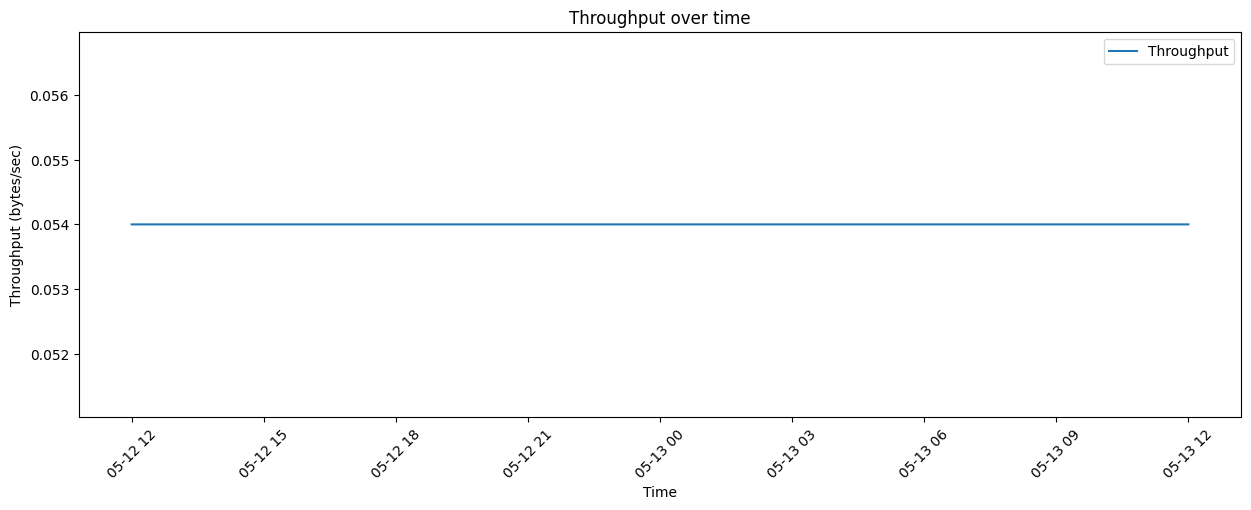

In [132]:
# Plot the RSSI over time
plt.figure(figsize=(15, 5))
sns.lineplot(data=df_day_one, x=df_day_one.index, y="throughput(bytes/sec)", label="Throughput")
plt.xlabel("Time")
plt.ylabel("Throughput (bytes/sec)")
plt.title("Throughput over time")
plt.xticks(rotation=45)
plt.show()

### Exploratory Data Analysis

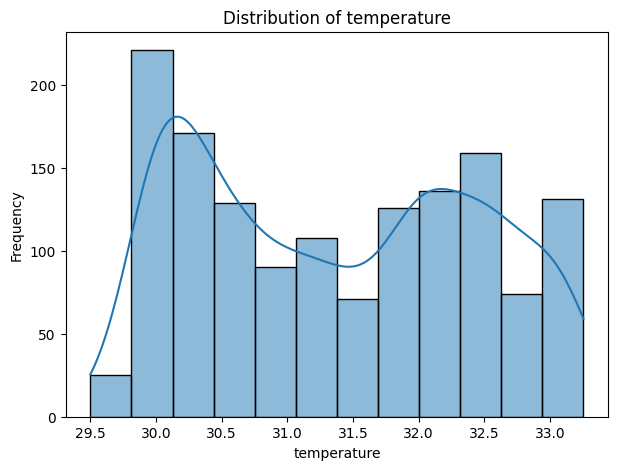

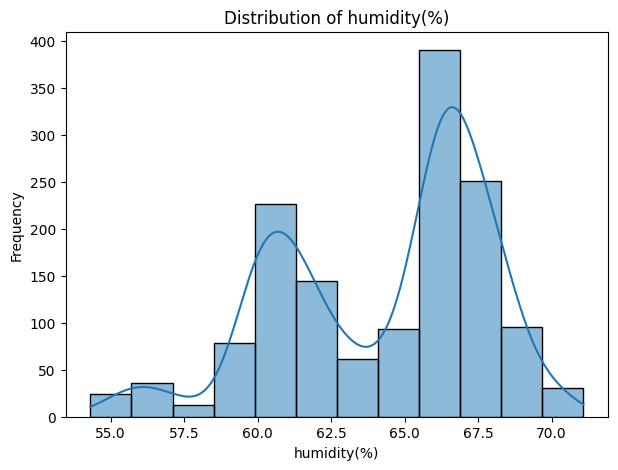

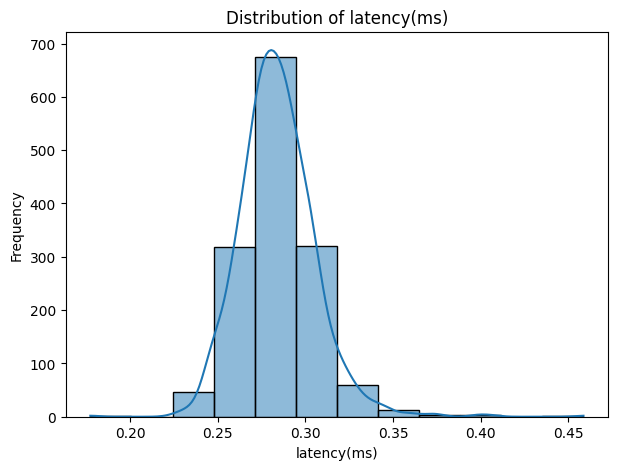

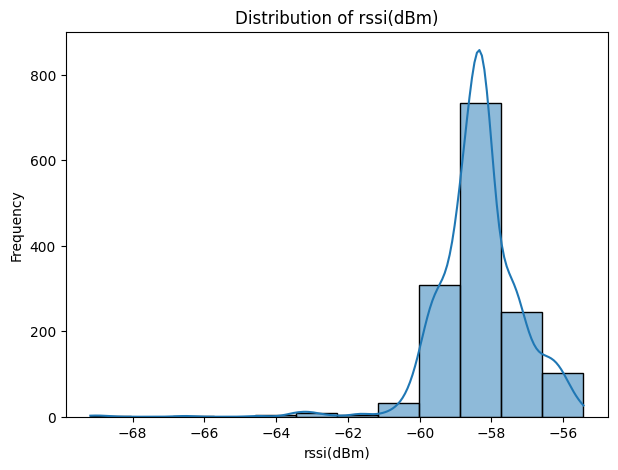

In [133]:
# Exclude the last columns, packet_loss(%) and throughput(bytes/sec)
df_one_day = df_day_one.drop(columns=["packet_loss(%)", "throughput(bytes/sec)", "time_str"])

# Visualize the distribution of the data
for i in df_one_day.columns:
    plt.figure(figsize=(7, 5))
    sns.histplot(data=df_one_day, x=i, bins=12, kde=True)
    plt.xlabel(i)
    plt.ylabel("Frequency")
    plt.title(f"Distribution of {i}")
    plt.show()

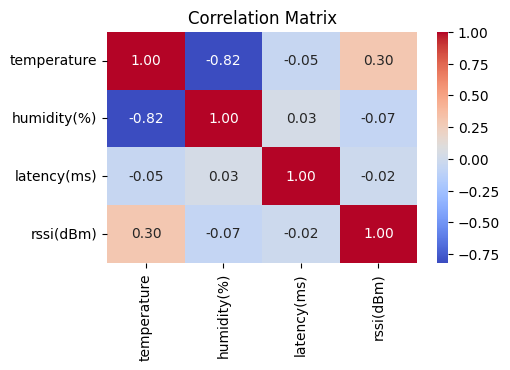

In [134]:
# Plot the correlation matrix with timestamp
plt.figure(figsize=(5, 3))
sns.heatmap(df_one_day.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

## Arima Model Building

In [135]:
import sys
import os
from statsmodels.tsa.stattools import adfuller
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.utils.utils import plot_acf_pacf, check_data_type

In [136]:
# Check the data type of the columns
check_data_type(df_one_day)

Column: temperature
Data Type: float64

Column: humidity(%)
Data Type: float64

Column: latency(ms)
Data Type: float64

Column: rssi(dBm)
Data Type: float64



In [137]:
# Function to check the stationarity of the time series
series = [df_one_day["temperature"], df_one_day["humidity(%)"], df_one_day["latency(ms)"], df_one_day["rssi(dBm)"]]

for i in series:
    result = adfuller(i, autolag='AIC')
    print(f'Augmented Dickey-Fuller Test for {i.name}')
    print(f'ADF Statistic: {result[0]}')
    print(f'n_lags: {result[1]}')
    print(f'p-value: {result[1]}\n')  

Augmented Dickey-Fuller Test for temperature
ADF Statistic: -0.21214533407924316
n_lags: 0.9370583566765273
p-value: 0.9370583566765273

Augmented Dickey-Fuller Test for humidity(%)
ADF Statistic: -1.1369048349921052
n_lags: 0.7001326266284643
p-value: 0.7001326266284643

Augmented Dickey-Fuller Test for latency(ms)
ADF Statistic: -19.923430934248174
n_lags: 0.0
p-value: 0.0

Augmented Dickey-Fuller Test for rssi(dBm)
ADF Statistic: -5.205720945469987
n_lags: 8.558688239871566e-06
p-value: 8.558688239871566e-06



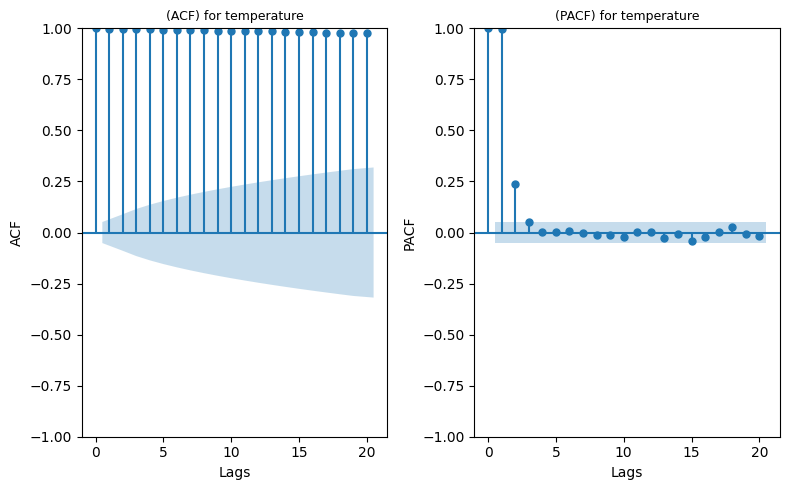

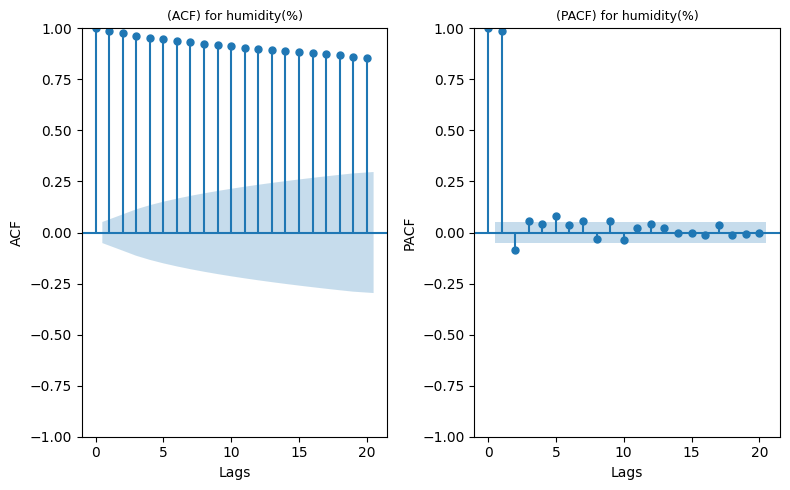

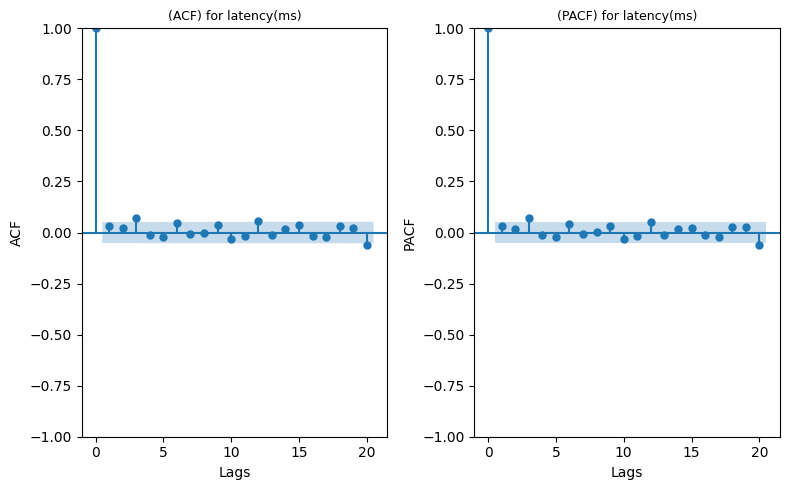

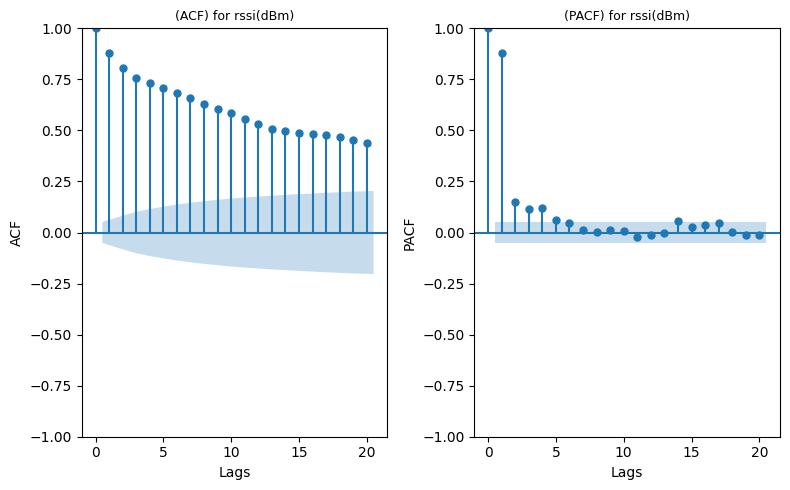

In [138]:
# Check the stationartity by Plotting the ACF and PACF
for col in df_one_day.columns:
  plot_acf_pacf(df_one_day[col], lags=20, title=col)

In [139]:
# Differencing the columns
df_one_day_diff = df_one_day.diff().dropna()

In [140]:
# Function to check the stationarity of the time series
series = [df_one_day_diff["temperature"], df_one_day_diff["humidity(%)"], df_one_day_diff["latency(ms)"], df_one_day_diff["rssi(dBm)"]]

for i in series:
    result = adfuller(i, autolag='AIC')
    print(f'Augmented Dickey-Fuller Test after differencing for {i.name}')
    print(f'ADF Statistic: {result[0]}')
    print(f'n_lags: {result[1]}')
    print(f'p-value: {result[1]}\n')  

Augmented Dickey-Fuller Test after differencing for temperature
ADF Statistic: -33.176476482279995
n_lags: 0.0
p-value: 0.0

Augmented Dickey-Fuller Test after differencing for humidity(%)
ADF Statistic: -13.526675813439024
n_lags: 2.6702086062390485e-25
p-value: 2.6702086062390485e-25

Augmented Dickey-Fuller Test after differencing for latency(ms)
ADF Statistic: -13.22942876700007
n_lags: 9.652011343170798e-25
p-value: 9.652011343170798e-25

Augmented Dickey-Fuller Test after differencing for rssi(dBm)
ADF Statistic: -13.373286426291067
n_lags: 5.14703475523906e-25
p-value: 5.14703475523906e-25



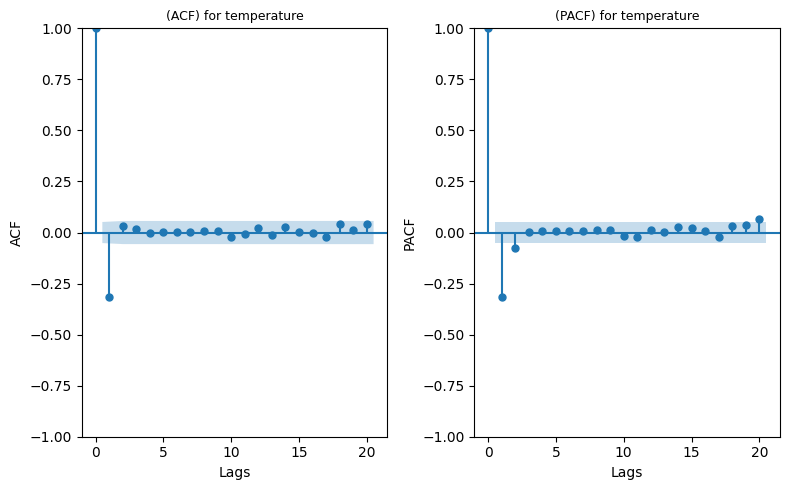

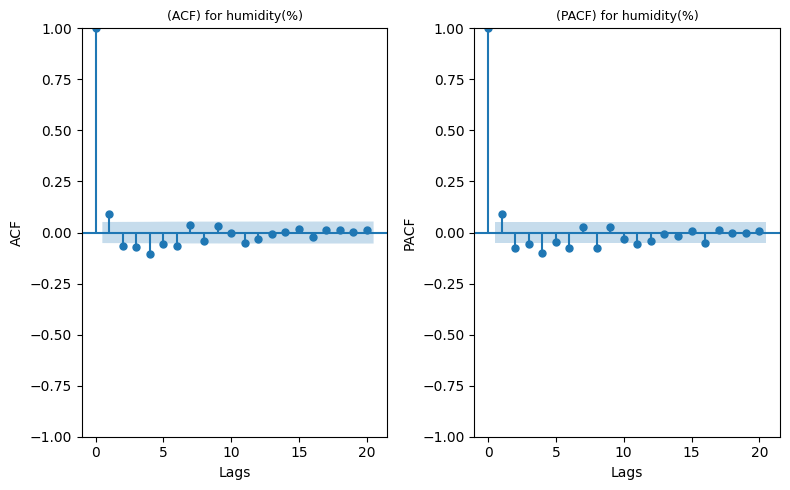

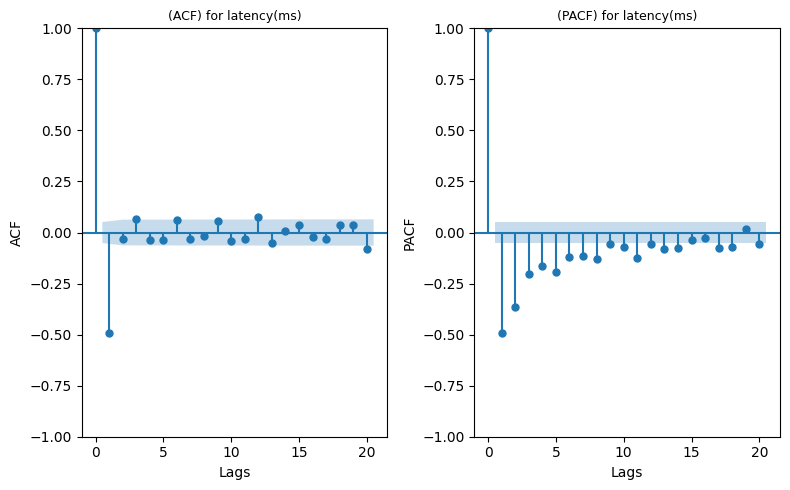

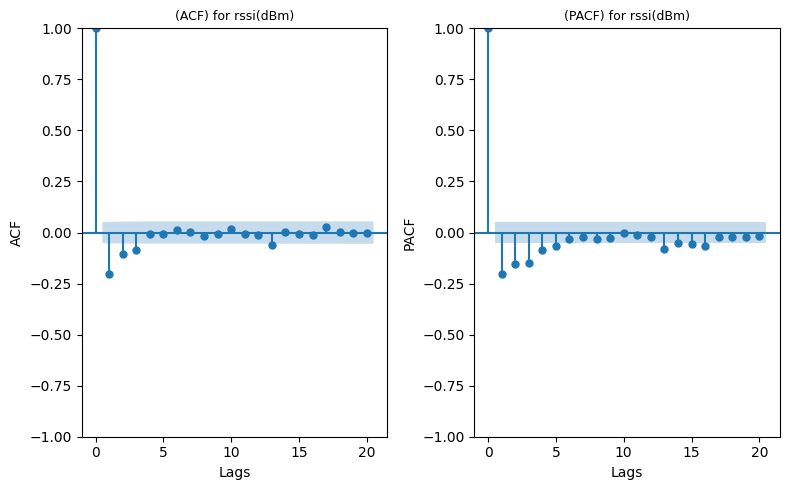

In [141]:
# Plot the ACF and PACF of the differenced data
for col in df_one_day_diff.columns:
  plot_acf_pacf(df_one_day_diff[col], lags=20, title=col)


In [142]:
# Split data into train and test
train_size = int(len(df_one_day_diff) * 0.8)
train, test = df_one_day_diff.iloc[:train_size], df_one_day_diff.iloc[train_size:]

c:\Kuliah\Semester 6\Signal Processing and Multimedia Services\Project\pslm-project\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)
c:\Kuliah\Semester 6\Signal Processing and Multimedia Services\Project\pslm-project\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)
c:\Kuliah\Semester 6\Signal Processing and Multimedia Services\Project\pslm-project\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)


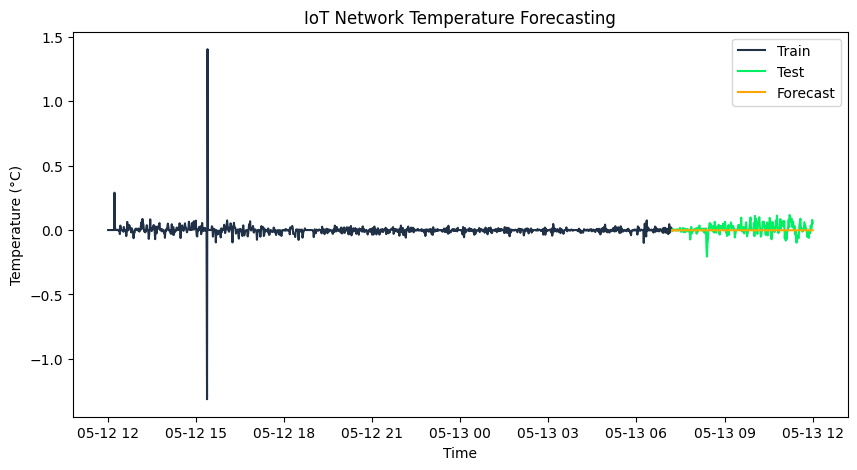

Mean Absolute Error: 0.03
Root Mean Squared Error: 0.04
Mean Squared Error: 0.00
Temperature Model Summary:
AIC: -3399.49
BIC: -3384.34


In [143]:
# Build the ARIMA model for temperature and plot the forecast
from statsmodels.tsa.arima.model import ARIMA
model_temp = ARIMA(train["temperature"], order=(1, 1, 1))
model_fit_temp = model_temp.fit()

# Visualize the model
forecast = model_fit_temp.forecast(steps=len(test))

# Plot the results with specified colors
plt.figure(figsize=(10,5))
plt.plot(train.index, train["temperature"], label='Train', color='#203147')
plt.plot(test.index, test["temperature"], label='Test', color='#01ef63')
plt.plot(test.index, forecast, label='Forecast', color='orange')
plt.title("IoT Network Temperature Forecasting")
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

# Evaluate the model
from sklearn.metrics import mean_squared_error, mean_absolute_error

forecast_temp = forecast[:len(test)]
test_temp = test["temperature"][:len(forecast)]

mae = mean_absolute_error(test_temp, forecast)
rmse = np.sqrt(mean_squared_error(test_temp, forecast))
mse = mean_squared_error(test_temp, forecast)

# Print the evaluation metrics
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Squared Error: {mse:.2f}")

# Print the AIC and BIC of the model
print("Temperature Model Summary:")
print(f"AIC: {model_fit_temp.aic:.2f}")
print(f"BIC: {model_fit_temp.bic:.2f}")

c:\Kuliah\Semester 6\Signal Processing and Multimedia Services\Project\pslm-project\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)
c:\Kuliah\Semester 6\Signal Processing and Multimedia Services\Project\pslm-project\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)
c:\Kuliah\Semester 6\Signal Processing and Multimedia Services\Project\pslm-project\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)


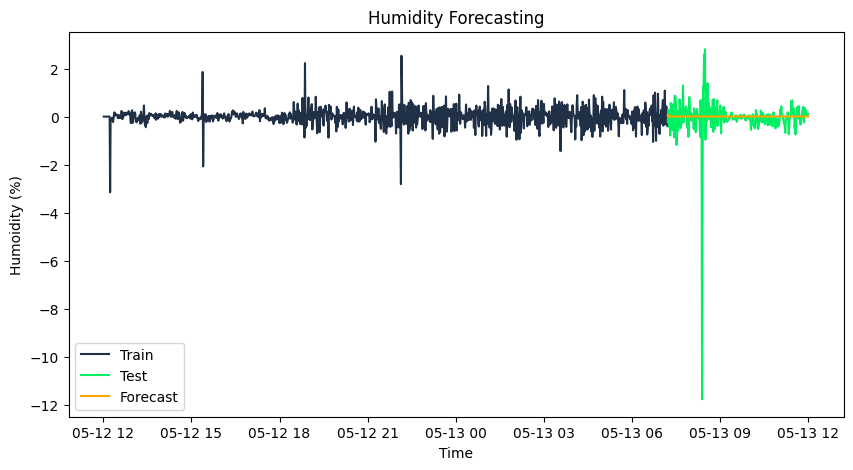

Mean Absolute Error: 0.33
Root Mean Squared Error: 0.84
Mean Squared Error: 0.70
Humidity Model Summary:
AIC: 875.49
BIC: 890.63


In [144]:
# Build the ARIMA model for humidity(%) and plot the forecast
from statsmodels.tsa.arima.model import ARIMA
model_hum = ARIMA(train["humidity(%)"], order=(1, 1, 1))
model_fit_hum = model_hum.fit()

# Visualize the model
forecast = model_fit_hum.forecast(steps=len(test))

# Plot the results with specified colors
plt.figure(figsize=(10,5))
plt.plot(train.index, train["humidity(%)"], label='Train', color='#203147')
plt.plot(test.index, test["humidity(%)"], label='Test', color='#01ef63')
plt.plot(test.index, forecast, label='Forecast', color='orange')
plt.title("Humidity Forecasting")
plt.xlabel('Time')
plt.ylabel('Humoidity (%)')
plt.legend()
plt.show()

# Evaluate the model
from sklearn.metrics import mean_squared_error, mean_absolute_error

forecast_hum = forecast[:len(test)]
test_temp = test["humidity(%)"][:len(forecast)]

mae = mean_absolute_error(test_temp, forecast)
rmse = np.sqrt(mean_squared_error(test_temp, forecast))
mse = mean_squared_error(test_temp, forecast)

# Print the evaluation metrics
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Squared Error: {mse:.2f}")
\
# Print the AIC and BIC of the model
print("Humidity Model Summary:")
print(f"AIC: {model_fit_hum.aic:.2f}")
print(f"BIC: {model_fit_hum.bic:.2f}")

c:\Kuliah\Semester 6\Signal Processing and Multimedia Services\Project\pslm-project\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)
c:\Kuliah\Semester 6\Signal Processing and Multimedia Services\Project\pslm-project\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)
c:\Kuliah\Semester 6\Signal Processing and Multimedia Services\Project\pslm-project\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)


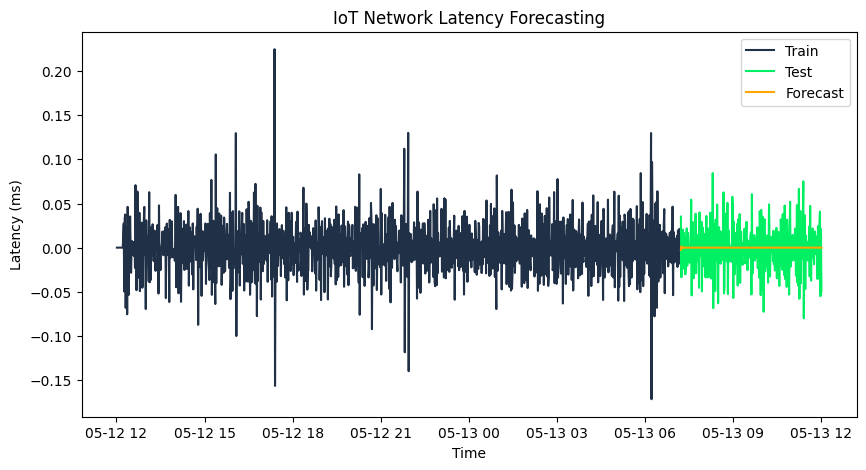

Mean Absolute Error: 0.02
Root Mean Squared Error: 0.03
Mean Squared Error: 0.00
Latency Model Summary:
AIC: -5047.86
BIC: -5032.71


In [145]:
# Build the ARIMA model for latency(%) and plot the forecast
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train["latency(ms)"], order=(1, 1, 1))
model_fit = model.fit()

# Visualize the model
forecast = model_fit.forecast(steps=len(test))

# Plot the results with specified colors
plt.figure(figsize=(10,5))
plt.plot(train.index, train["latency(ms)"], label='Train', color='#203147')
plt.plot(test.index, test["latency(ms)"], label='Test', color='#01ef63')
plt.plot(test.index, forecast, label='Forecast', color='orange')
plt.title("IoT Network Latency Forecasting")
plt.xlabel('Time')
plt.ylabel('Latency (ms)')
plt.legend()
plt.show()

# Evaluate the model
from sklearn.metrics import mean_squared_error, mean_absolute_error

forecast = forecast[:len(test)]
test_temp = test["latency(ms)"][:len(forecast)]

mae = mean_absolute_error(test_temp, forecast)
rmse = np.sqrt(mean_squared_error(test_temp, forecast))
mse = mean_squared_error(test_temp, forecast)

# Print the evaluation metrics
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Squared Error: {mse:.2f}")

# Print the AIC and BIC of the model
print("Latency Model Summary:")
print(f"AIC: {model_fit.aic:.2f}")
print(f"BIC: {model_fit.bic:.2f}")

c:\Kuliah\Semester 6\Signal Processing and Multimedia Services\Project\pslm-project\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)
c:\Kuliah\Semester 6\Signal Processing and Multimedia Services\Project\pslm-project\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)
c:\Kuliah\Semester 6\Signal Processing and Multimedia Services\Project\pslm-project\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)


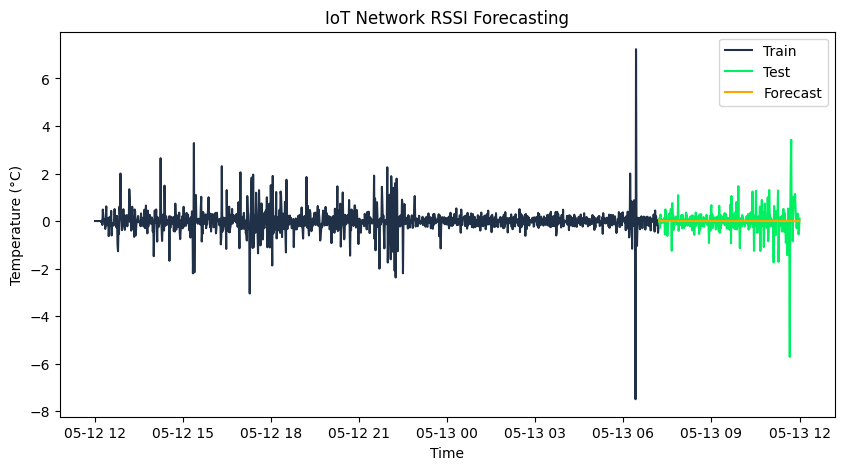

Mean Absolute Error: 0.34
Root Mean Squared Error: 0.60
Mean Squared Error: 0.36
RSSI Model Summary:
AIC: 1916.93
BIC: 1932.07


In [146]:
# Build the ARIMA model for latency(%) and plot the forecast
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train["rssi(dBm)"], order=(1, 1, 1))
model_fit = model.fit()

# Visualize the model
forecast = model_fit.forecast(steps=len(test))

# Plot the results with specified colors
plt.figure(figsize=(10,5))
plt.plot(train.index, train["rssi(dBm)"], label='Train', color='#203147')
plt.plot(test.index, test["rssi(dBm)"], label='Test', color='#01ef63')
plt.plot(test.index, forecast, label='Forecast', color='orange')
plt.title("IoT Network RSSI Forecasting")
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

# Evaluate the model
from sklearn.metrics import mean_squared_error, mean_absolute_error

forecast = forecast[:len(test)]
test_temp = test["rssi(dBm)"][:len(forecast)]

mae = mean_absolute_error(test_temp, forecast)
rmse = np.sqrt(mean_squared_error(test_temp, forecast))
mse = mean_squared_error(test_temp, forecast)

# Print the evaluation metrics
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Squared Error: {mse:.2f}")

# Print the AIC and BIC of the model
print("RSSI Model Summary:")
print(f"AIC: {model_fit.aic:.2f}")
print(f"BIC: {model_fit.bic:.2f}")